In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys
sys.path.insert(0, "./")
import tensorflow as tf
import basic_block, utils, load_data
import time
import os
import matplotlib.pyplot as plt
import numpy as np


### Check https://www.tensorflow.org/tensorboard/r2/get_started for more info
# Load the TensorBoard notebook extension
# For Jupyter notebook
%load_ext tensorboard.notebook
# For Colab
# %load_ext tensorboard
import datetime

In [12]:
!rm -rf ./logs/ 

In [18]:
def restor_img(img):
    try:
        img = img.numpy()
    except:
        pass
    img -= img.min()
    print(img.min(), img.max())
    return img / img.max() 

In [20]:
### https://www.tensorflow.org/tensorboard/r2/get_started
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

In [27]:
### For training, checkout https://www.tensorflow.org/api_docs/python/tf/keras/models/Model
###                        https://www.tensorflow.org/tensorboard/r2/get_started
def train(style_list, content_list, save_model_dir,batch_size=1, num_epochs=10, style_weight=1, content_weight=1,
          ngf=64, log_interval=1, lr=1e-5):
    ########################
    # Data loader
    ########################

    content_loader = load_data.get_dataloader(content_list, batch_size, target_size=(300,400))
    style_loader = load_data.get_dataloader(style_list, batch_size, target_size=(300, 400))
    
    ########################
    # Init model
    ########################  
    vgg = basic_block.Vgg()
    style_model = basic_block.Net(ngf = ngf)
    ########################
    # optimizer and loss
    ########################
#     mse_loss = tf.losses.mean_squared_error
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    ########################
    # Start training loop
    ########################
    for epoch in range(num_epochs):
        print(epoch)
        # Why don't we have style_model.train() method in our code?
        agg_content_loss = 0.0
        agg_style_loss = 0.0
        count = 0
        
        content_loader_iter = iter(content_loader)
        style_loader_iter = iter(style_loader)
        
        for batch_id, content_img in enumerate(content_loader_iter):
            with tf.GradientTape() as tape:
                # Need to watch variables in order to compute their gradients
#                 tape.watch(style_model.trainable_variables)
                
                # Update batch and count number #
                n_batch = len(content_img)
                count += n_batch
                ####### Maybe need to reset the gradient (did so in PyTorch)??
                content_img = utils.preprocess_batch(content_img)
                                
                # Load style image and initialize gram matrix and other stuff in style_model 
                style_image = next(style_loader_iter)
                style_image = utils.preprocess_batch(style_image) ### We need this line becuase their style_loader.get function performs this preprocessing internally
                
                
                style_model.set_target(style_image)
#                 plt.imshow(restor_img(style_image[0]))
#                 plt.title("style")
#                 plt.show()
                
#                 plt.imshow(restor_img(content_img[0]))
#                 plt.title("content")
#                 plt.show()



                # Normalize the data points based on mean of large dataset in ImageNet and feed it into vgg 
                style_image = utils.subtract_imagenet_mean_batch(style_image)
                feature_style = vgg(style_image)
                gram_style = [utils.gram_matrix(y) for y in feature_style] #### First, this gram matrix is located in wrong file. Second, the tensor used in original paper has shape (b, ch, h, w), whereas somehow we assume (b, h, w, ch) in our implementation 
                
#                 y = style_model(content_img)
#                 xc = content_img ##### Bill is not sure this is correct. But creating a new node in graph doesn't seem correct

                #### This section is for visualization purpose only
#                 print(content_img)
                im = style_model(content_img)[0]
                plt.imshow(restor_img(im))
                plt.title("result")
                plt.show()
                
#                 # Process images which get feed into VGG and used for loss computation
#                 y = utils.subtract_imagenet_mean_batch(y)
#                 xc = utils.subtract_imagenet_mean_batch(xc)
                
                features_y = vgg(utils.subtract_imagenet_mean_batch(style_model(content_img)))
                feature_xc = vgg(utils.subtract_imagenet_mean_batch(content_img))

                f_xc_c = feature_xc[1]
  
                
                #print(y.shape, content_img.shape)
                #print(features_y[1].shape, f_xc_c.shape)
                
                # TODO: why the coefficient 2?
#                 content_loss = 2 * content_weight * tf.math.reduce_sum(mse_loss(features_y[1], f_xc_c,))
                
                
#                 b, h, w, ch = features_y[1].shape
#                 features_y[1] = tf.reshape(features_y[1], [b*h*w, ch])
#                 f_xc_c = tf.reshape(f_xc_c, [b*h*w, ch])
#                 print("Content: ", features_y[1].shape, f_xc_c.shape, np.prod(f_xc_c.shape))
                
#                 print(tf.reduce_sum(tf.pow(features_y[1] - f_xc_c, 2))/ np.prod(f_xc_c.shape))
#                 print(tf.reduce_mean(tf.square(features_y[1] - f_xc_c)))
#                 print(tf.reduce_mean(tf.losses.mean_squared_error(features_y[1], f_xc_c)))
#                 print(tf.math.equal(tf.reduce_mean(tf.square(features_y[1] - f_xc_c)), tf.reduce_mean(tf.losses.mean_squared_error(features_y[1], f_xc_c))))
                
                
                content_loss = content_weight * tf.reduce_mean(tf.square(features_y[1] - f_xc_c))
                
                style_loss = 0.0
                for m in range(len(features_y)):
                
                    
                    gram_y = utils.gram_matrix(features_y[m])
                    gram_s = gram_style[m]
#                     print("Style: ", gram_y.shape, gram_s[:n_batch, :, :].shape)
                    layer_loss = style_weight * tf.reduce_mean(tf.square(gram_y, gram_s[:n_batch, :, :]))
                    print("Loss of layer {} in VGG: {}".format(m+1, layer_loss))
                    style_loss += layer_loss
                total_loss = content_loss + style_loss
                agg_content_loss += content_loss
                agg_style_loss += style_loss

            ### in original code, optimizer performs step immediately after calculating total_loss. Whey do we update gradient outside the tape region??
            ### Also, we do we have variables and trainable_variables????????
            gradients = tape.gradient(total_loss, style_model.variables)
            optimizer.apply_gradients(zip(gradients, style_model.trainable_variables))
            ### https://www.tensorflow.org/tensorboard/r2/get_started
            train_loss(total_loss)
           
            
            
#             for g, v in zip(gradients, style_model.trainable_variables):
#                 print(v.name)

                
                
            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\tcontent: {:.3f}\tstyle: {:.3f}\ttotal: {:.3f}".format(
                    time.ctime(), epoch + 1,
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

#             if (batch_id + 1) % (4 * log_interval) == 0:
#                 # save model
#                 save_model_filename = "Epoch_" + str(epoch) + "iters_" + \
#                     str(count) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
#                     content_weight) + "_" + str(style_weight) + ".params"
#                 save_model_path = os.path.join(save_model_dir, save_model_filename)
#                 tf.saved_model.save(style_model, save_model_path)
#                 print("\nCheckpoint, trained model saved at", save_model_path)




        ### https://www.tensorflow.org/tensorboard/r2/get_started
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)



        template = 'Epoch {}, Loss: {}' #, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print (template.format(epoch+1, train_loss.result())) 
                               #train_accuracy.result()*100,
                               #test_loss.result(), 
                               #test_accuracy.result()*100))

        # Reset metrics every epoch
        train_loss.reset_states()

In [28]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)

0
0.0 0.00047186262


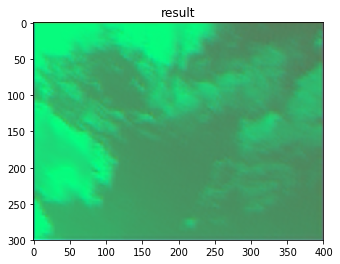

Loss of layer 1 in VGG: 307374.8125
Loss of layer 2 in VGG: 15431.98046875
Loss of layer 3 in VGG: 386.94415283203125
Loss of layer 4 in VGG: 0.0039156703278422356
Fri May 10 13:22:23 2019	Epoch 1:	content: 67791.555	style: 323193.719	total: 390985.281
Epoch 1, Loss: 390985.28125
1
0.0 0.0028511821


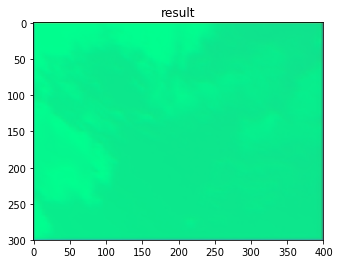

Loss of layer 1 in VGG: 301338.5
Loss of layer 2 in VGG: 15165.5234375
Loss of layer 3 in VGG: 381.0710754394531
Loss of layer 4 in VGG: 0.0038737535942345858
Fri May 10 13:22:40 2019	Epoch 2:	content: 67551.805	style: 316885.094	total: 384436.906
Epoch 2, Loss: 384436.90625
2
0.0 0.0054285983


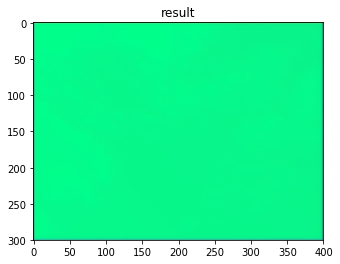

Loss of layer 1 in VGG: 294735.9375
Loss of layer 2 in VGG: 14870.34375
Loss of layer 3 in VGG: 373.0489501953125
Loss of layer 4 in VGG: 0.0038177729584276676
Fri May 10 13:22:58 2019	Epoch 3:	content: 67284.914	style: 309979.344	total: 377264.250
Epoch 3, Loss: 377264.25
3
0.0 0.008087677


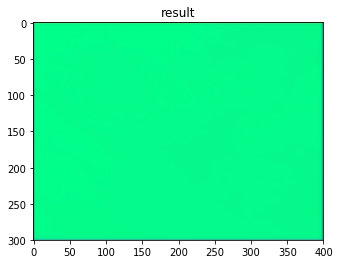

Loss of layer 1 in VGG: 288277.1875
Loss of layer 2 in VGG: 14578.0234375
Loss of layer 3 in VGG: 364.6138916015625
Loss of layer 4 in VGG: 0.0037603017408400774
Fri May 10 13:23:14 2019	Epoch 4:	content: 66995.594	style: 303219.844	total: 370215.438
Epoch 4, Loss: 370215.4375
4
0.0 0.010846222


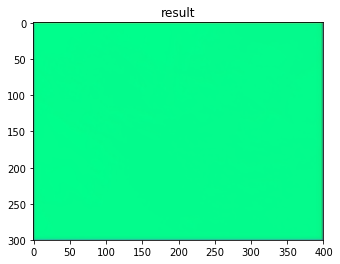

Loss of layer 1 in VGG: 281937.8125
Loss of layer 2 in VGG: 14254.2138671875
Loss of layer 3 in VGG: 354.57305908203125
Loss of layer 4 in VGG: 0.003683565417304635
Fri May 10 13:23:33 2019	Epoch 5:	content: 66658.008	style: 296546.594	total: 363204.594
Epoch 5, Loss: 363204.59375


In [35]:
style_list = load_data.get_data_paths("style")
content_list = load_data.get_data_paths("content")
train(style_list, content_list, "models", num_epochs=5, style_weight=1, content_weight=1)

In [33]:
%tensorboard --logdir logs/gradient_tape

TypeError: _repr_pretty_() takes 1 positional argument but 3 were given

TypeError: _repr_pretty_() takes 1 positional argument but 3 were given

In [17]:
style_list = load_data.get_data_paths("style")
content_list = load_data.get_data_paths("content")
train(style_list, content_list, "models", num_epochs=50, style_weight=10, content_weight=1)

KeyboardInterrupt: 